# Ultrasonic Flaw Size Regression: Model Inference and Visualization

## Nondestructive Testing (NDT) Problem Statement

Ultrasonic Testing (UT) uses high frequency sound energy to conduct examinations and make measurements. UT can be used for flaw detection/evaluation, dimensional measurements, material characterization, and more. In a typical pulse/echo inspection, a pulser/receiver generates high voltage pulses that drive a transducer to emit ultrasonic waves. These waves propagate through materials, and when a discontinuity (such as a crack) is present, part of the energy is reflected back. The reflected signal is converted to an electrical signal and displayed, allowing for the detection and characterization of flaws. Signal travel time relates to the distance traveled, and the signal can provide information about the reflector's location, size, and orientation.

This notebook demonstrates how to use a trained CNN model for flaw size regression on ultrasonic data. It covers data loading, model inference, and visualization of predictions versus ground truth.


2025-06-29 12:22:56.111 | INFO     | darkvision.modeling.predict:load_model:42 - Loading model from D:\CML\Term 8\ML projects\Ultrasonic Image Analysis\ultrasonic_workspace\models\checkpoint_epoch_100.pt
2025-06-29 12:22:56.220 | INFO     | darkvision.modeling.predict:load_model:51 - Model trained for 100 epochs
2025-06-29 12:22:56.220 | SUCCESS  | darkvision.modeling.predict:load_model:55 - Model loaded successfully
2025-06-29 12:22:56.220 | INFO     | darkvision.modeling.predict:predict_batch:135 - Making batch predictions on 200 batches
2025-06-29 12:22:56.783 | INFO     | darkvision.modeling.predict:predict_batch:153 - Batch predictions completed. Total samples: 200
2025-06-29 12:22:56.783 | INFO     | darkvision.modeling.predict:predict_batch:153 - Batch predictions completed. Total samples: 200


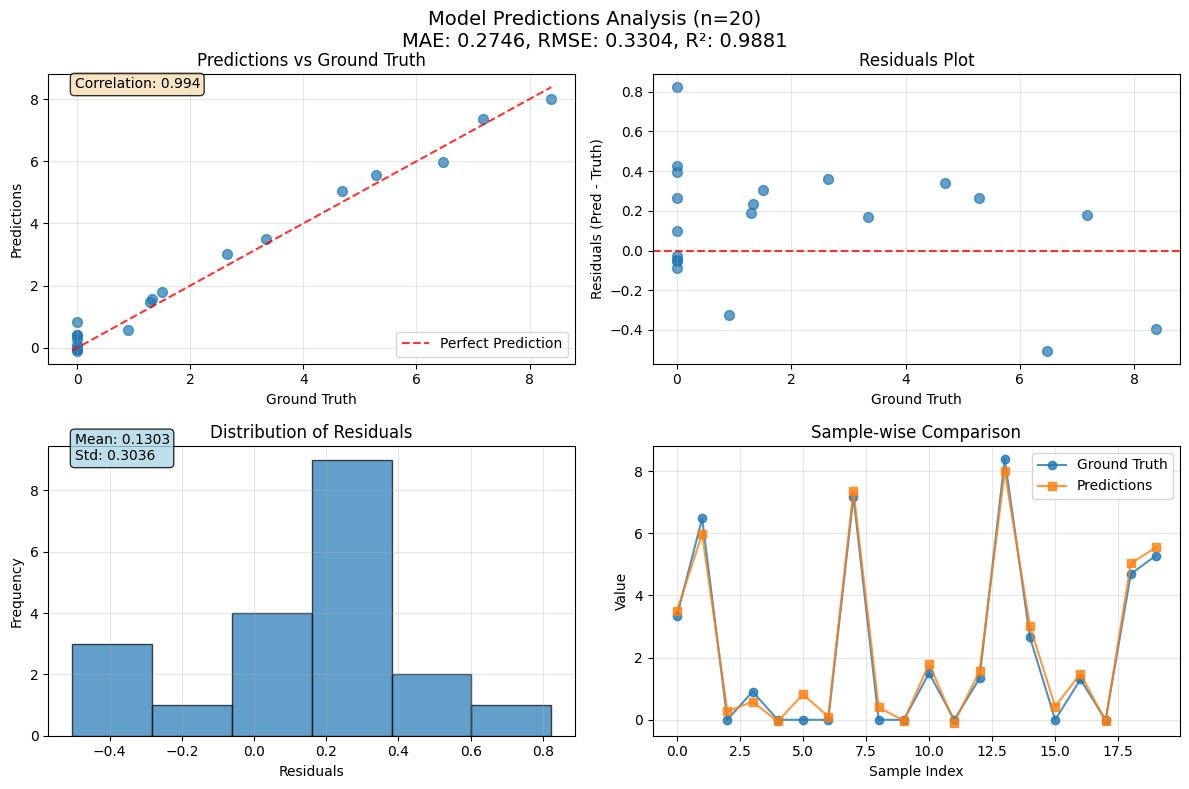

In [3]:
# Plot predictions vs ground truth for test samples (same as plot_predictions CLI)
import numpy as np
import torch
import matplotlib.pyplot as plt
from darkvision.modeling.predict import load_model, predict_batch
from darkvision.dataset import get_dataloader
from darkvision.config import PROCESSED_DATA_DIR, MODELS_DIR, RANDOM_STATE
import random

# Set random seed for reproducibility
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Load model
model_path = MODELS_DIR / "checkpoint_epoch_100.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model(model_path, device)

# Load test data
test_dir = PROCESSED_DATA_DIR / "test"
test_loader = get_dataloader(test_dir, batch_size=1, shuffle=False)

# Get all predictions
all_predictions, all_ground_truths = predict_batch(test_loader, model, device)

n_samples = 20
if n_samples > len(all_predictions):
    n_samples = len(all_predictions)
selected_indices = random.sample(range(len(all_predictions)), n_samples)
predictions = all_predictions[selected_indices]
ground_truths = all_ground_truths[selected_indices]

plt.figure(figsize=(12, 8))
# Scatter plot
plt.subplot(2, 2, 1)
plt.scatter(ground_truths, predictions, alpha=0.7, s=50)
min_val = min(min(ground_truths), min(predictions))
max_val = max(max(ground_truths), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground Truth')
plt.legend()
plt.grid(True, alpha=0.3)
correlation = np.corrcoef(ground_truths, predictions)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
# Residuals plot
plt.subplot(2, 2, 2)
residuals = predictions - ground_truths
plt.scatter(ground_truths, residuals, alpha=0.7, s=50)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('Ground Truth')
plt.ylabel('Residuals (Pred - Truth)')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)
# Histogram of residuals
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=min(15, n_samples//3), alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
plt.text(0.05, 0.95, f'Mean: {mean_residual:.4f}\nStd: {std_residual:.4f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
# Sample indices plot
plt.subplot(2, 2, 4)
sample_indices = np.arange(n_samples)
plt.plot(sample_indices, ground_truths, 'o-', label='Ground Truth', alpha=0.8)
plt.plot(sample_indices, predictions, 's-', label='Predictions', alpha=0.8)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Sample-wise Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
mae = np.mean(np.abs(residuals))
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
plt.suptitle(f'Model Predictions Analysis (n={n_samples})\nMAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {correlation**2:.4f}', fontsize=14, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()